# Ensemble-Additive Model: Lower Back Pain Symptom 

[Data Set Source](https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset)   

## Imports

In [50]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm_notebook
from sklearn.utils import shuffle

## Loading Data
#### 310 Observations, 13 Attributes (12 Numeric Predictors, 1 Binary Class Attribute - No Demographics)

In [51]:
df = pd.read_csv("/Users/zorazhang/Desktop/backPainSymp.csv")
df = df.drop(df.columns[13], axis=1)
df.columns = ['pelvic incidence', 'pelvic tilt', 'lumbar lordosis angle', 'sacral slope', 'pelvic radius', 'degree spondylolisthesis', 'pelvic slope', 'direct tilt', 'thoracic slope', 'cervical tilt', 'sacrum angle', 'scoliosis slope', 'result']
df['result'] = df['result'].map({'Abnormal': 1, 'Normal': 0})
df = shuffle(df)
df.head()

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,degree spondylolisthesis,pelvic slope,direct tilt,thoracic slope,cervical tilt,sacrum angle,scoliosis slope,result
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,1
103,49.782121,6.466805,53.000000,43.315316,110.864783,25.335647,0.334657,17.6515,11.7040,16.26239,-0.895590,38.4719,1
52,50.209670,29.760122,36.104007,20.449548,128.292515,5.740614,0.031139,36.1431,13.9907,12.90967,-30.430498,31.6999,1
19,41.729963,12.254074,30.122586,29.475889,116.585706,-1.244402,0.468526,28.5598,12.4637,14.19610,-20.392538,33.0265,1
101,79.938570,18.774071,63.311835,61.164499,114.787107,38.538741,0.708887,11.2935,10.9220,7.17197,-34.653679,28.1835,1


## Net
#### Each net has 2 hidden layers, each layer has 300 nodes, M = 5

In [52]:
class Net(nn.Module):
    def __init__(self, layerWidth=300):
        super(Net, self).__init__();
        self.fc1 = nn.Linear(1, layerWidth)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(layerWidth, layerWidth)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(layerWidth, layerWidth)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.fc4 = nn.Linear(layerWidth,1)
        nn.init.kaiming_normal_(self.fc4.weight)
    def forward (self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#### Create a 2D neural networks array: nets

In [53]:
nets = []
for i in range(5):
    subnets = []
    for i in range(len(df.columns)):
        subnets.append( Net() )
    nets.append(subnets)

## Minibatch
#### 5 batches, each contains 50 rows

In [54]:
batches = []
for i in range (5):
    batch = df.sample(n = 50,replace = True)
    batches.append(batch)

#### Split each batch into Inputs and Targets

In [91]:
# 5 groups of 12-column inputs
inputs = []
# 5 groups of 1-column target
targets = []
# All the column names
titles = []
for i in range(len(batches)):
    titles = np.array((batches[i].columns))
    inputs.append(batches[i].iloc[:, 0:len(df.columns) - 1])
    targets.append(batches[i]['result'])
print(inputs[1].shape)
titles = titles[:-1]
print(titles)

(50, 12)
['pelvic incidence' 'pelvic tilt' 'lumbar lordosis angle' 'sacral slope'
 'pelvic radius' 'degree spondylolisthesis' 'pelvic slope' 'direct tilt'
 'thoracic slope' 'cervical tilt' 'sacrum angle' 'scoliosis slope']


#### Organize inputs into a torch tensor: In

In [112]:
In = []
for index in range(len(inputs)):
    subIn = []
    for i, feature in enumerate(titles):
        columnInput = torch.from_numpy(np.array(inputs[index][feature])).float().reshape(-1,1)
        subIn.append(columnInput)
    In.append(subIn)

# Usage format: 
# print(In[0][11])
# 0 denotes the batch index, 11 denotes the feature index

#### Organize targets into a torch tensor: Target

In [115]:
Target = []
for index in range (len(targets)):
    columnTarget = torch.from_numpy(np.array(targets[index])).float().reshape(-1,1)
    Target.append(columnTarget)

# Usage format:
# print(Target[0])
# 0 denotes the batch index

## Training

In [121]:
for i, net in enumerate(nets):
    
    netTarget = Target[i]
    netInput = In[i] 
        
    optimizers = [optim.Adam(net[i].parameters()) for i in range(len(net))]
    criterion = nn.MSELoss()
    epochs = tqdm_notebook(range(1000))

    for epoch in epochs:

        for optimizer in optimizers:
            optimizer.zero_grad()

        Out = [net[i](netInput[i]) for i in range(len(net) - 1)]
        totalOut = sum(Out)
        loss = criterion(totalOut, netTarget)
        loss.backward()

        for optimizer in optimizers:
            optimizer.step()

        epochs.set_description(str(loss.data.item()))


0.12319295853376389


## Plotting

#### Each net's performance on different symptoms

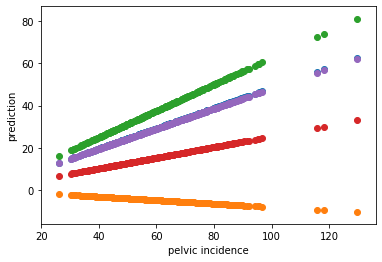

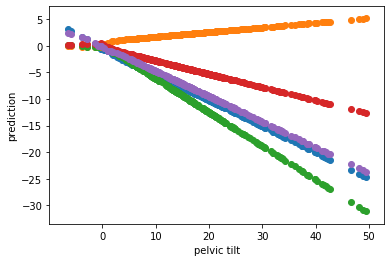

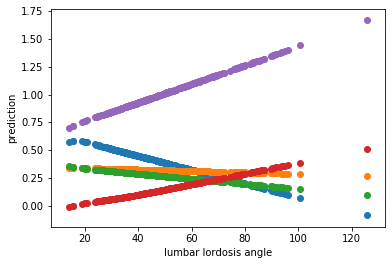

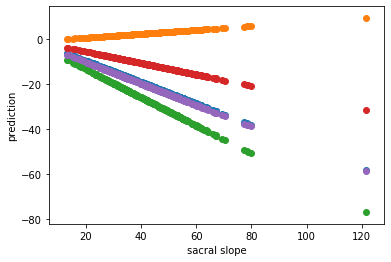

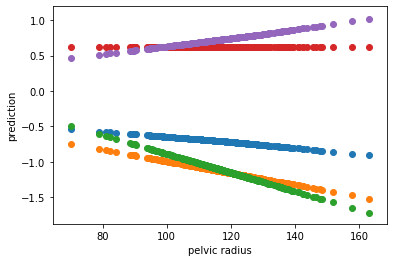

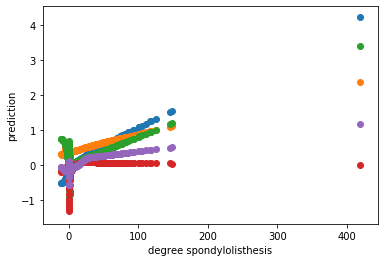

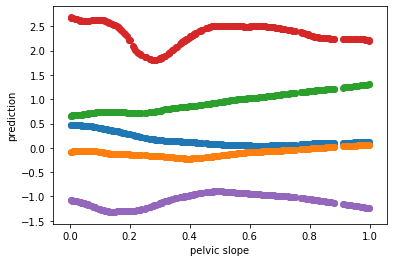

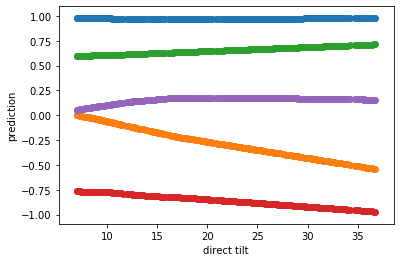

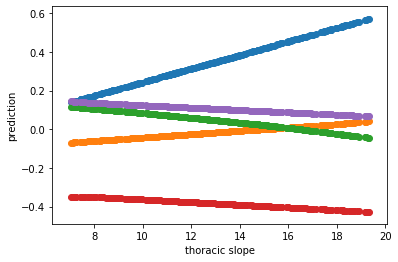

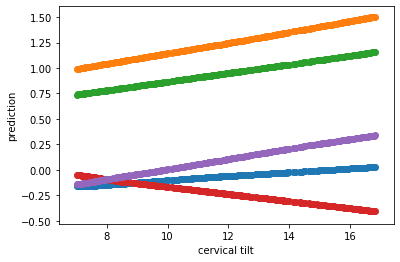

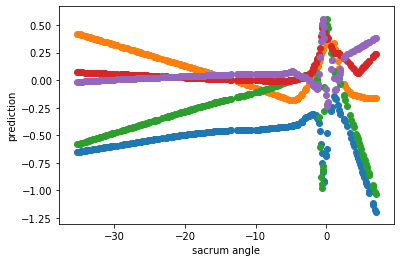

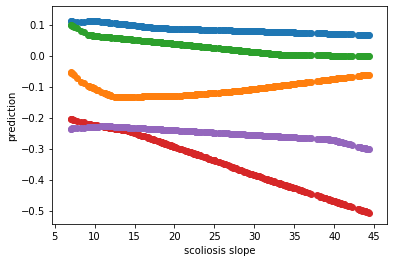

In [149]:
for i, feature in enumerate(titles):
    for n in range (5):
        mynet = nets[n]
        allInput = np.array(df[feature])
        tensorAllInput = torch.from_numpy(allInput).float().reshape(-1,1)
        tensorAllOut = mynet[i](tensorAllInput)
        allOut = tensorAllOut.detach().numpy()
        plt.scatter(allInput, allOut)
        plt.xlabel(feature)
        plt.ylabel('prediction')
    plt.show()